In [2]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from utils import plot_images
from image_datasets import load_nist_data
from tqdm import tqdm 

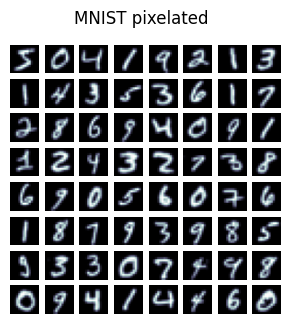

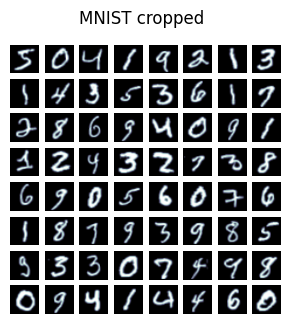

In [21]:
cmap='bone'

data = load_nist_data(name='MNIST', distortion='pixelize', level=0.5,unet_resize=True)
dataloader_a = DataLoader(data, batch_size=64, shuffle=False)
images, _ = next(iter(dataloader_a))
plot_images(images, "MNIST pixelated", figsize=(3.5, 3.5), cmap=cmap)

data = load_nist_data(name='MNIST', distortion='swirl', level=1.,unet_resize=True)
dataloader_b = DataLoader(data, batch_size=64, shuffle=False)
images, _ = next(iter(dataloader_b))
plot_images(images, "MNIST cropped", figsize=(3.5, 3.5), cmap=cmap)

In [5]:
import torch
import torch.nn.functional as F
from torchvision.models import inception_v3
from scipy.linalg import sqrtm
import numpy as np
from torchvision.transforms import functional as Fv

def preprocess_image(image):
    image = image.permute(0, 3, 1, 2) / 255.0
    return Fv.center_crop(image, (256, 256))
    
def calculate_fid(act1, act2):
    # calculate mean and covariance statistics
    mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)
    # calculate sum squared difference between means
    ssdiff = np.sum((mu1 - mu2)**2.0)
    # calculate sqrt of product between cov
    covmean = sqrtm(sigma1.dot(sigma2))
    # check and correct imaginary numbers from sqrt
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    # calculate score
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

def get_inception_features(model, dataloader, device,number_of_images=100):
    model.eval()
    features = []
    images_left = number_of_images
    with torch.no_grad():
        for data_ in tqdm(dataloader):
            data = data_[0]
            batch_size = data.size(0)
            take_n_images = min(images_left,batch_size)
            data = data[:take_n_images]
            if data.size(1) == 1:
                data = data.repeat(1,3,1,1)
            data = preprocess_image(data)
            data = data.to(device)
            pred = model(data)
            features.append(F.softmax(pred, dim=1).detach().cpu().numpy())
            images_left -= take_n_images
            if images_left <= 0:
                break

            
    features = np.concatenate(features, axis=0)
    return features

In [6]:
# Load Inception model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
inception_model = inception_v3(pretrained=True)
inception_model.fc = torch.nn.Identity()
inception_model.to(device)

C:\Users\cesar\anaconda4\envs\rate_matching\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\cesar\anaconda4\envs\rate_matching\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [12]:
# Get features from inception model
fake_features = get_inception_features(inception_model, dataloader_b, device,number_of_images=100)

  0%|                                                                                     | 1/938 [00:07<1:54:41,  7.34s/it]


In [13]:
# Calculate FID
fid_score = calculate_fid(real_features, fake_features)
print(f'FID score: {fid_score}')

FID score: 4.328833688568729e+112


In [15]:
values=np.arange(0.0, 1, 0.02)

In [24]:
data = load_nist_data(name='MNIST', distortion='binerize', level=0.5)
dataloader_0 = DataLoader(data, batch_size=64, shuffle=False)
real_features = get_inception_features(inception_model, dataloader_0, device,number_of_images=100)

  0%|                                                                                     | 1/938 [00:04<1:15:26,  4.83s/it]


In [26]:
FID = []
#...Distorted datasets:
values=np.arange(0.1, 1, 0.02)
for value in values:
    print(f"Current Value {value}")
    data = load_nist_data(name='MNIST', distortion='binerize', level=value)
    dataloader_b = DataLoader(data, batch_size=64, shuffle=False)
    fake_features = get_inception_features(inception_model, dataloader_b, device,number_of_images=100)
    images, _ = next(iter(dataloader_b))
    plot_images(images, "MNIST cropped", figsize=(3.5, 3.5), cmap=cmap)
    fid_score = calculate_fid(real_features, fake_features)
    print(f'FID score: {fid_score}')
    FID.append(fid_score)

Current Value 0.1


  0%|                                                                                     | 1/938 [00:04<1:16:27,  4.90s/it]


FID score: 2.8581389654278078e-12
Current Value 0.12000000000000001


  0%|                                                                                     | 1/938 [00:04<1:15:37,  4.84s/it]


FID score: 2.8581389654278078e-12
Current Value 0.14


  0%|                                                                                     | 1/938 [00:05<1:20:14,  5.14s/it]


FID score: 2.8581389654278078e-12
Current Value 0.16000000000000003


  0%|                                                                                     | 1/938 [00:05<1:29:45,  5.75s/it]


FID score: 2.8581389654278078e-12
Current Value 0.18000000000000002


  0%|                                                                                     | 1/938 [00:05<1:22:13,  5.27s/it]


FID score: 2.8581389654278078e-12
Current Value 0.2


  0%|                                                                                     | 1/938 [00:05<1:22:27,  5.28s/it]


FID score: 2.8581389654278078e-12
Current Value 0.22000000000000003


  0%|                                                                                     | 1/938 [00:05<1:25:49,  5.50s/it]


FID score: 2.8581389654278078e-12
Current Value 0.24000000000000002


  0%|                                                                                     | 1/938 [00:05<1:25:34,  5.48s/it]


FID score: 2.8581389654278078e-12
Current Value 0.26


  0%|                                                                                     | 1/938 [00:05<1:30:45,  5.81s/it]


FID score: 2.8581389654278078e-12
Current Value 0.28


  0%|                                                                                     | 1/938 [00:06<1:44:45,  6.71s/it]


FID score: 2.8581389654278078e-12
Current Value 0.30000000000000004


  0%|                                                                                     | 1/938 [00:07<2:03:32,  7.91s/it]


FID score: 2.8581389654278078e-12
Current Value 0.32000000000000006


  0%|                                                                                     | 1/938 [00:07<2:00:10,  7.70s/it]


FID score: 0.0
Current Value 0.3400000000000001


  0%|                                                                                     | 1/938 [00:07<1:52:09,  7.18s/it]


FID score: 0.0
Current Value 0.3600000000000001


  0%|                                                                                     | 1/938 [00:07<1:52:49,  7.23s/it]


FID score: 0.0
Current Value 0.38


  0%|                                                                                     | 1/938 [00:07<1:53:26,  7.26s/it]


FID score: 0.0
Current Value 0.4


  0%|                                                                                     | 1/938 [00:06<1:48:36,  6.95s/it]


FID score: 0.0
Current Value 0.42000000000000004


  0%|                                                                                     | 1/938 [00:06<1:48:37,  6.96s/it]


FID score: 0.0
Current Value 0.44000000000000006


  0%|                                                                                     | 1/938 [00:06<1:47:18,  6.87s/it]


FID score: 0.0
Current Value 0.4600000000000001


  0%|                                                                                     | 1/938 [00:07<1:51:15,  7.12s/it]


FID score: 0.0
Current Value 0.4800000000000001


  0%|                                                                                     | 1/938 [00:06<1:47:46,  6.90s/it]


FID score: 0.0
Current Value 0.5000000000000001


  0%|                                                                                     | 1/938 [00:06<1:48:22,  6.94s/it]


FID score: 0.0
Current Value 0.5200000000000001


  0%|                                                                                     | 1/938 [00:07<1:50:00,  7.04s/it]


FID score: 0.0
Current Value 0.54


  0%|                                                                                     | 1/938 [00:07<1:51:59,  7.17s/it]


FID score: 0.0
Current Value 0.56


  0%|                                                                                     | 1/938 [00:06<1:48:38,  6.96s/it]


FID score: 0.0
Current Value 0.5800000000000001


  0%|                                                                                     | 1/938 [00:07<1:51:56,  7.17s/it]


FID score: 0.0
Current Value 0.6000000000000001


  0%|                                                                                     | 1/938 [00:07<1:51:00,  7.11s/it]


FID score: 0.0
Current Value 0.6200000000000001


  0%|                                                                                     | 1/938 [00:07<1:49:45,  7.03s/it]


FID score: 0.0
Current Value 0.6400000000000001


  0%|                                                                                     | 1/938 [00:06<1:49:13,  6.99s/it]


FID score: 0.0
Current Value 0.66


  0%|                                                                                     | 1/938 [00:08<2:17:00,  8.77s/it]


FID score: 0.0
Current Value 0.68


  0%|                                                                                     | 1/938 [00:09<2:25:45,  9.33s/it]


FID score: 0.0
Current Value 0.7000000000000001


  0%|                                                                                     | 1/938 [00:08<2:06:43,  8.11s/it]


FID score: 0.0
Current Value 0.7200000000000001


  0%|                                                                                     | 1/938 [00:07<1:56:55,  7.49s/it]


FID score: 0.0
Current Value 0.7400000000000001


  0%|                                                                                     | 1/938 [00:07<1:58:39,  7.60s/it]


FID score: 0.0
Current Value 0.7600000000000001


  0%|                                                                                     | 1/938 [00:07<1:55:31,  7.40s/it]


FID score: 0.0
Current Value 0.7800000000000001


  0%|                                                                                     | 1/938 [00:07<1:52:06,  7.18s/it]


FID score: 0.0
Current Value 0.8000000000000002


  0%|                                                                                     | 1/938 [00:07<1:50:26,  7.07s/it]


FID score: 0.0
Current Value 0.8200000000000002


  0%|                                                                                     | 1/938 [00:06<1:45:41,  6.77s/it]


FID score: 0.0
Current Value 0.8400000000000001


  0%|                                                                                     | 1/938 [00:08<2:07:54,  8.19s/it]


FID score: 0.0
Current Value 0.8600000000000001


  0%|                                                                                     | 1/938 [00:07<2:02:54,  7.87s/it]


FID score: 0.0
Current Value 0.8800000000000001


  0%|                                                                                     | 1/938 [00:06<1:49:09,  6.99s/it]


FID score: 0.0
Current Value 0.9000000000000001


  0%|                                                                                     | 1/938 [00:06<1:47:59,  6.91s/it]


FID score: 0.0
Current Value 0.9200000000000002


  0%|                                                                                     | 1/938 [00:06<1:47:49,  6.90s/it]


FID score: 0.0
Current Value 0.9400000000000002


  0%|                                                                                     | 1/938 [00:07<1:49:57,  7.04s/it]


FID score: 0.0
Current Value 0.9600000000000002


  0%|                                                                                     | 1/938 [00:08<2:14:09,  8.59s/it]


FID score: 0.0
Current Value 0.9800000000000001


  0%|                                                                                     | 1/938 [00:10<2:37:31, 10.09s/it]


FID score: 0.0


In [ ]:
dataset = load_nist_data(name=name, train=False)
mu, sigma = compute_activation_statistics(model, dataset, batch_size=batch_size, activation_layer=activation_layer, device=device)
fid = {}

for val in values:
    dataset = load_nist_data(name, distortion=distortion, level=val, train=False)
    fid[val] = compute_fid(model, dataset, mu_ref=mu, sigma_ref=sigma, batch_size=batch_size, activation_layer=activation_layer, device=device).cpu()
return fid